In [1]:
import coffea
import uproot
import awkward as ak
import hist
import os
import numpy as np
import pickle

In [2]:
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib as mpl
import boost_histogram as bh
mpl.rc('image', cmap='Reds')
plt.style.use(hep.style.CMS)

# Bend distribution

In [3]:
bend_axis = hist.axis.Regular(80, -10, 10, name="Bend")
link_axis = hist.axis.IntCategory(range(3), name="Link")

h_noShielding = hist.Hist(bend_axis, link_axis)
h_withShielding = hist.Hist(bend_axis, link_axis)

In [4]:
file_exists = os.path.isfile("bend_distributions.pkl")

if not(file_exists):
    ###----
    n_total = 0
    n_coincidence = 0
    for array in uproot.iterate("run_2008/2008_*.root:cbmsim", ["Bend", "Link"], step_size=10000000):
        h_noShielding.fill(ak.flatten(array["Bend"]), ak.flatten(array["Link"]))
        link = array["Link"]
        n_total += len(link)
        mask = (ak.num(link)>2)&(ak.any(link == 0, axis=1))&(ak.any(link == 1, axis=1))&(ak.any(link == 2, axis=1))
        n_coincidence += ak.sum(mask)
    print("fraction of events with 3 module coincidence: ", n_coincidence/n_total)
    print("Done filling 'h_noShielding' histogram.")
    ###----
    n_total = 0
    n_coincidence = 0
    for array in uproot.iterate("run_2014/2014_*.root:cbmsim", ["Bend", "Link"], step_size=10000000):
        h_withShielding.fill(ak.flatten(array["Bend"]), ak.flatten(array["Link"]))
        link = array["Link"]
        n_total += len(link)
        mask = (ak.num(link)>2)&(ak.any(link == 0, axis=1))&(ak.any(link == 1, axis=1))&(ak.any(link == 2, axis=1))
        n_coincidence += ak.sum(mask)
    print("fraction of events with 3 module coincidence: ", n_coincidence/n_total)
    print("Done filling 'h_withShielding' histogram.")
    ###----
    print("Writing to a pkl file so I don't have to read the files every time.")
    out = {}; out["h_noShielding"] = h_noShielding; out["h_withShielding"] = h_withShielding;
    with open('bend_distributions.pkl', 'wb') as f:
        pickle.dump(out, f)
    

fraction of events with 3 module coincidence:  0.4980532267168826
Done filling 'h_noShielding' histogram.
fraction of events with 3 module coincidence:  0.4750489913315353
Done filling 'h_withShielding' histogram.
Writing to a pkl file so I don't have to read the files every time.


In [5]:
with open('bend_distributions.pkl', 'rb') as f:
    out = pickle.load(f)

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


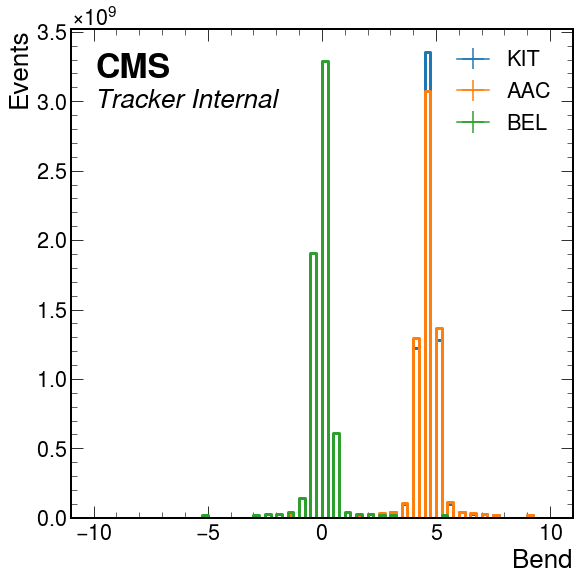

In [6]:
fig, ax  = plt.subplots(figsize=(9,9))
hep.cms.text(ax=ax,loc=2, text = "Tracker Internal")
ax.set_xlabel("Bend")
ax.set_ylabel("Events")
ax.ticklabel_format(useMathText=True)
hep.histplot([out["h_noShielding"][:, 0], out["h_noShielding"][:, 1], out["h_noShielding"][:, 2]], label=["KIT", "AAC", "BEL"], linewidth=3, density=False)
ax.legend()
fig.savefig("bend_noShielding.pdf", bbox_inches='tight')

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


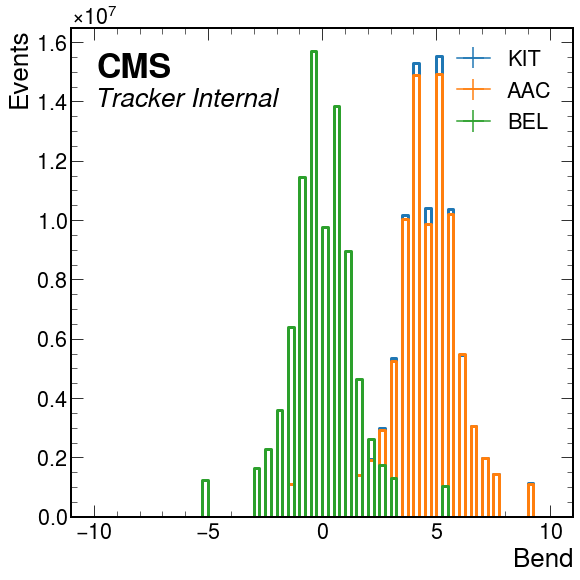

In [7]:
fig, ax  = plt.subplots(figsize=(9,9))
hep.cms.text(ax=ax,loc=2, text = "Tracker Internal")
ax.set_xlabel("Bend")
ax.set_ylabel("Events")
ax.ticklabel_format(useMathText=True)
hep.histplot([out["h_withShielding"][:, 0], out["h_withShielding"][:, 1], out["h_withShielding"][:, 2]], label=["KIT", "AAC", "BEL"], linewidth=3, density=False)
ax.legend()
fig.savefig("bend_withShielding.pdf", bbox_inches='tight')

# StubX distribution

In [8]:
strip_axis = hist.axis.Variable(range(1036), name="Strip number")
CIC_axis = hist.axis.Variable([0, 0.5, 1.0], name="CIC")
link_axis = hist.axis.IntCategory(range(3), name="Link")
Bx_axis = hist.axis.Regular(3600, 0, 3600, name="Bx")
superID_axis = hist.axis.Regular(50, 0, 1035, name="SuperID")
event_axis = hist.axis.IntCategory(range(6), name="Event")

h_eventStub = hist.Hist(strip_axis, CIC_axis, link_axis, event_axis)
h_stub = hist.Hist(strip_axis, CIC_axis, link_axis)

In [9]:
## looking into partial run 2014 for event plots
eve = 0
for array in uproot.iterate("run_2014/2014_0a*.root:cbmsim", ["LocalX", "LocalY", "Link", "Bx", "SuperID"], step_size=10000000):
    ievents = eve
    X, CIC, link = array["LocalX"], array["LocalY"], array["Link"]
    h_stub.fill(ak.flatten(X), ak.flatten(CIC), ak.flatten(link))
    
    # event = array["SuperID"]+array["Bx"] 
    ## looking for events with coincidence in the three modules
    mask = (ak.num(link)>2)&(ak.any(link == 0, axis=1))&(ak.any(link == 1, axis=1))&(ak.any(link == 2, axis=1))
    eve += ak.sum(mask)
    if (eve < 5):
        # print("X: ", X[mask])
        h_eventStub.fill(ak.flatten(X[mask]), ak.flatten(CIC[mask]), ak.flatten(link[mask]), ak.flatten(ak.broadcast_arrays(X[mask], np.arange(ievents, eve))[1]))
    else:
        break

In [10]:
for event in range(4):
    fig, ax  = plt.subplots(figsize=(30,9), nrows=1, ncols=3)
    for link in range(3):
        title={0: "KIT", 1: "AAC", 2: "BEL"}
        ax[link].legend(title=title[link])
        hep.cms.text(ax=ax[link],loc=2, text = "Tracker Internal")
        hep.hist2dplot(h_eventStub[::bh.rebin(4), :, link, hist.loc(event)], vmin=0, vmax=1, ax=ax[link], cbar=False)
        ax[link].set_ylim(-0.5,1.5)
    fig.savefig("event{}_hits.pdf".format(event), bbox_inches='tight');
    plt.close(fig)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
No handles with labels found t